##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

#### Import & Utils

Install JAX, Tensorflow Datasets, and Neural Tangents.

The first line specifies the version of jaxlib that we would like to import. Note, that "cp36" species the version of python (version 3.6) used by JAX. Make sure your colab kernel matches this version.

In [1]:
# !pip install -q --upgrade pip
# !pip install -q --upgrade jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install -q tensorflow-datasets
!pip install -q git+https://www.github.com/google/neural-tangents

  Preparing metadata (setup.py) ... done


Import libraries

In [15]:
from jax import jit
from jax import grad
from jax import random

import jax.numpy as jnp
from jax.nn import log_softmax
from jax.example_libraries import optimizers

import tensorflow_datasets as tfds

import neural_tangents as nt
from neural_tangents import stax

import random as rd

from tqdm import tqdm

import matplotlib.pyplot as plt

Define helper functions for processing data and introducing label noise

In [3]:
def process_data(data_chunk):
  """Flatten the images and one-hot encode the labels."""
  image, label = data_chunk['image'], data_chunk['label']

  samples = image.shape[0]
  image = jnp.array(jnp.reshape(image, (samples, -1)), dtype=jnp.float32)
  image = (image - jnp.mean(image)) / jnp.std(image)
  label_one_hot = jnp.eye(10)[label] # onl one hot encode before training
  label = jnp.array(label, dtype=jnp.int32)

  return {'image': image, 'label_one_hot': label_one_hot, 'label': label}

In [4]:
def introduce_label_noise(labels, n_classes, noise_level=0.1, key=random.PRNGKey(0)):
  """
  Introduce noise to the labels using Bernoulli distribution.
  """
  n_samples = labels.shape[0]
  # Use Bernoulli distribution to determine which indices will be noisy
  noise_mask = random.bernoulli(key, p=noise_level, shape=(n_samples,))
  noisy_indices = jnp.where(noise_mask)[0]

  # Generate new random labels for the selected indices
  new_labels = random.randint(key, shape=(noisy_indices.shape[0],), minval=0, maxval=n_classes)

  # Create noisy labels
  noisy_labels = labels.at[noisy_indices].set(new_labels)
  return noisy_labels

# Function Space Linearization

experiment parameters

In [5]:
learning_rate = 1e-3
training_steps = jnp.arange(10000)
print_every = 100.0
batch_size = 64
dataset_size = 64
noise_level = 0.5

load the dataset


In [6]:
ds_train, ds_test = tfds.as_numpy(
    tfds.load('cifar10', split=['train[:%d]' % dataset_size,
                                'test[:%d]' % dataset_size],
              batch_size=-1)
)

train = process_data(ds_train)
test = process_data(ds_test)

Create a Fully-Connected Network.

In [7]:
init_fn, f, _ = stax.serial(
    stax.Dense(512, parameterization='standard', W_std=1, b_std=1),
    stax.Erf(),
    stax.Dense(10, parameterization='standard', W_std=1, b_std=1))

key = random.PRNGKey(0)
_, init_params = init_fn(key, (-1, 3072))

jnp.linalg.norm(init_params[0][0], ord=2, axis=0).mean()

Array(1.0002224, dtype=float32)

Construct the NTK.

In [8]:
ntk = nt.batch(nt.empirical_ntk_fn(f, vmap_axes=0),
               batch_size=64, device_count=0)

g_dd = ntk(train['image'], None, init_params)
g_td = ntk(test['image'], train['image'], init_params)

Now that we have the NTK and a network we can compare against a number of different dynamics. Remember to reinitialize the network and NTK if you want to try a different dynamics.

## Gradient Descent & MSE Loss



Create an MSE loss and a gradient.

In [10]:
loss = lambda fx, y_hat: 0.5 * jnp.mean((fx - y_hat) ** 2)
grad_loss = jit(grad(lambda params, x, y: loss(f(params, x), y)))

Create a optimizer.

In [11]:
init_func, update_func, get_params = optimizers.sgd(learning_rate)

## Create an MSE predictor and compute the function space values.

In [13]:
predictor = nt.predict.gradient_descent_mse(g_dd, train['label_one_hot'],
                                            learning_rate=learning_rate)
fx_train_0 = f(init_params, train['image'])
fx_test_0 = f(init_params, test['image'])

fx_train_t, fx_test_t = predictor(training_steps, fx_train_0, fx_test_0, g_td)

## Train the network without label noise.

In [14]:
X_train, Y_train = train['image'], train['label_one_hot']
X_test, Y_test = test['image'], test['label_one_hot']

In [28]:
# print('Time\tTrain Loss\tLinear Train Loss\tTest Loss\tLinear Test Loss')

# initalize the optimizer
params = init_params
state = init_func(params)

iters = []
train_loss_clean_lst = []
train_loss_linear_lst = []
test_loss_clean_lst = []
test_loss_linear_lst = []
norm_mean_clean_lst = []
norm_std_clean_lst = []

for i in tqdm(training_steps):
  # sample mini-batch
  batch_indices = random.choice(random.PRNGKey(i), X_train.shape[0], shape=(batch_size,), replace=False)
  X_batch = X_train[batch_indices]
  Y_batch = Y_train[batch_indices]

  params = get_params(state)
  state = update_func(i, grad_loss(params, X_batch, Y_batch), state)

  if i % print_every == 0:
    train_loss_clean = loss(f(params, X_train), Y_train)
    train_loss_linear = loss(fx_train_t[i], Y_train)
    test_loss_clean = loss(f(params, X_test), Y_test)
    test_loss_linear = loss(fx_test_t[i], Y_test)

    # update
    iters.append(i)
    train_loss_clean_lst.append(train_loss_clean)
    train_loss_linear_lst.append(train_loss_linear)
    test_loss_clean_lst.append(test_loss_clean)
    test_loss_linear_lst.append(test_loss_linear)

    norms = jnp.linalg.norm(params[0][0], ord=2, axis=0)

    # update
    norm_mean_clean_lst.append(jnp.mean(norms))
    norm_std_clean_lst.append(jnp.std(norms))

    # print('{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(i, exact_loss, linear_loss, test_exact_loss, test_linear_loss))

100%|██████████| 10000/10000 [02:59<00:00, 55.77it/s]


## Train the network with label noise.

In [33]:
# print('Time\tTrain Loss\tLinear Train Loss\tTest Loss\tLinear Test Loss')

# initalize the optimizera
params = init_params
state = init_func(params)

iters = []
train_loss_noisy_lst = []
test_loss_noisy_lst = []
norm_mean_noisy_lst = []
norm_std_noisy_lst = []

for i in tqdm(training_steps):
  batch_indices = random.choice(random.PRNGKey(i), X_train.shape[0], shape=(batch_size,), replace=False)
  X_batch = X_train[batch_indices]
  Y_batch = train['label'][batch_indices]

  # introduce the label noise
  Y_noisy = introduce_label_noise(Y_batch, 10, noise_level=noise_level, key=random.PRNGKey(i))
  Y_noisy = jnp.eye(10)[Y_noisy] # one hot encode the noisy labels

  params = get_params(state)
  state = update_func(i, grad_loss(params, X_batch, Y_noisy), state)

  if i % print_every == 0:
    train_loss_noisy = loss(f(params, X_train), Y_train)
    test_loss_noisy = loss(f(params, X_test), Y_test)

    # update
    iters.append(i)
    train_loss_noisy_lst.append(train_loss_noisy)
    test_loss_noisy_lst.append(test_loss_noisy)

    norms = jnp.linalg.norm(params[0][0], ord=2, axis=0)

    # update
    norm_mean_noisy_lst.append(jnp.mean(norms))
    norm_std_noisy_lst.append(jnp.std(norms))

    # print('{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}'.format(i, exact_loss, linear_loss, test_exact_loss, test_linear_loss))

100%|██████████| 10000/10000 [04:21<00:00, 38.24it/s]


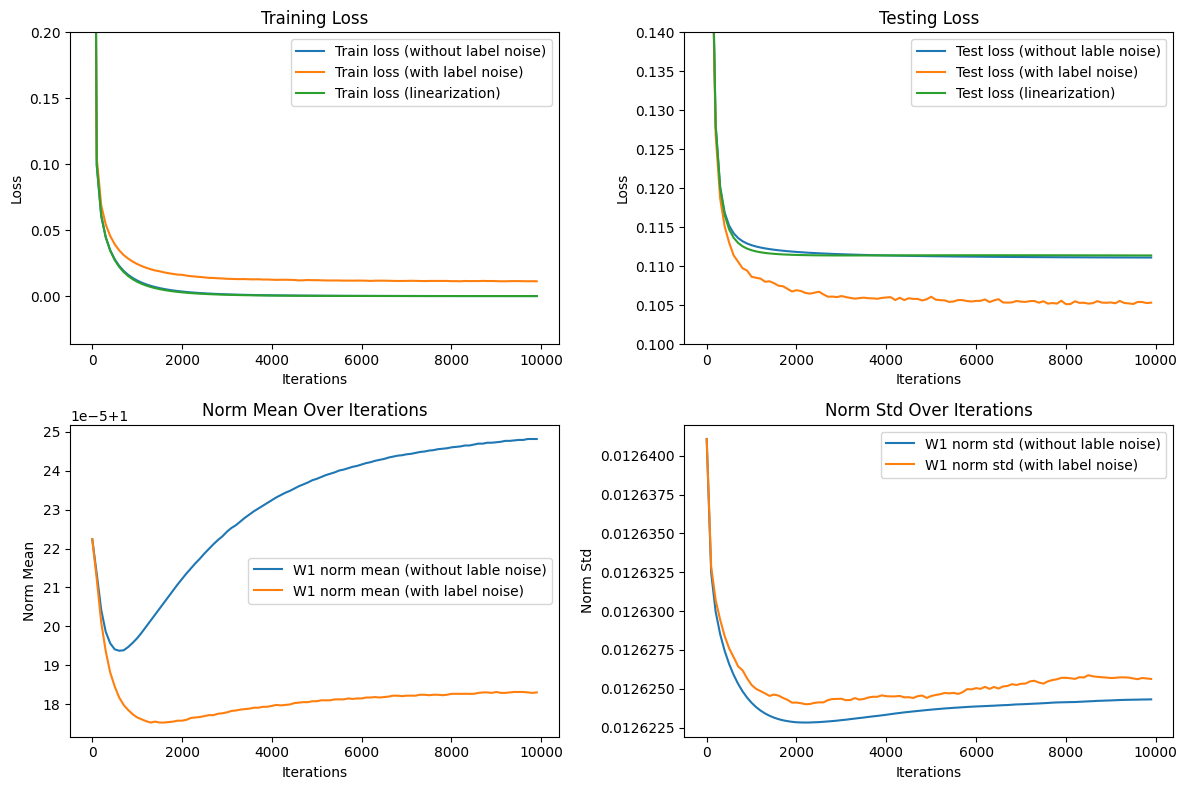

In [39]:
plt.figure(figsize=(12, 8))

# Plot Train and Test Loss
plt.subplot(2, 2, 1)
plt.plot(iters, train_loss_clean_lst, label='Train loss (without label noise)')
plt.plot(iters, train_loss_noisy_lst, label='Train loss (with label noise)')
plt.plot(iters, train_loss_linear_lst, label='Train loss (linearization)')
plt.ylim(top=0.2)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iters, test_loss_clean_lst, label='Test loss (without lable noise)')
plt.plot(iters, test_loss_noisy_lst, label='Test loss (with label noise)')
plt.plot(iters, test_loss_linear_lst, label='Test loss (linearization)')
plt.ylim(top=0.14, bottom=0.10)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Testing Loss')
plt.legend()

# Plot Norm Mean and Std
plt.subplot(2, 2, 3)
plt.plot(iters, norm_mean_clean_lst, label='W1 norm mean (without lable noise)')
plt.plot(iters, norm_mean_noisy_lst, label='W1 norm mean (with label noise)')
plt.xlabel('Iterations')
plt.ylabel('Norm Mean')
plt.title('Norm Mean Over Iterations')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iters, norm_std_clean_lst, label='W1 norm std (without lable noise)')
plt.plot(iters, norm_std_noisy_lst, label='W1 norm std (with label noise)')
plt.xlabel('Iterations')
plt.ylabel('Norm Std')
plt.title('Norm Std Over Iterations')
plt.legend()

plt.tight_layout()
plt.show()
